<a href="https://colab.research.google.com/github/CAVASOL/aiffel_quest/blob/main/Exploration_quest/exploration_4/xp4_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 8-1.프로젝트 : CIFAR-10 이미지 생성하기

**Creator: Yeon Kim**

**Index**

    Set up
    Step 1. 작업환경 구성하기
    STEP 2. 데이터셋 구성하기
    Step 3. 생성자 모델 구현하기
    STEP 4. 판별자 모델 구현하기
    STEP 5. 손실함수와 최적화 함수 구현하기
    STEP 6. 훈련과정 상세 기능 구현하기
    STEP 7. 학습 과정 진행하기
    STEP 8. (optional) GAN 훈련 과정 개선하기
    
    Conclusion
      Details
      Result
      Retrospect
      Reference

### Set up

In [ ]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print("tensorflow", tf.__version__)
print("imageio", imageio.__version__)

tensorflow 2.6.0
imageio 2.9.0


### Step 1. 작업환경 구성하기

In [ ]:
# mkdir -p ~/aiffel/dcgan_newimage/cifar10/generated_samples
# mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_checkpoints
# mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_history

### STEP 2. 데이터셋 구성하기

* 학습에 사용할 train_x의 이미지를 -1, 1로 정규화
* 로드한 학습 데이터를 시각화를 통해 확인
* tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하여 미니배치 데이터셋 구성

In [ ]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

170508288/170498071 [==============================] - 4s 0us/step


(50000, 32, 32, 3)

`CIFAR10` 데이터셋은 `32x32` 픽셀의 이미지로, 각 픽셀은 0~255 사이의 정숫값을 가집니다.

In [ ]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


train_x를 `정규화(-1과 1사이의 값으로 변경)` 합니다.

In [ ]:
train_x = (train_x - 127.5) / 127.5

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [ ]:
train_x.shape

(50000, 32, 32, 3)

로드한 학습 데이터를 시각화하여 확인해 봅시다.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


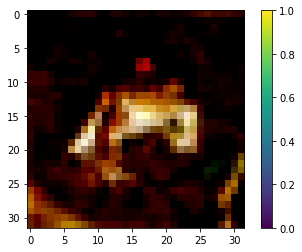

In [ ]:
# plt.style.use('seaborn-white')

plt.imshow(train_x[0])
plt.colorbar()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

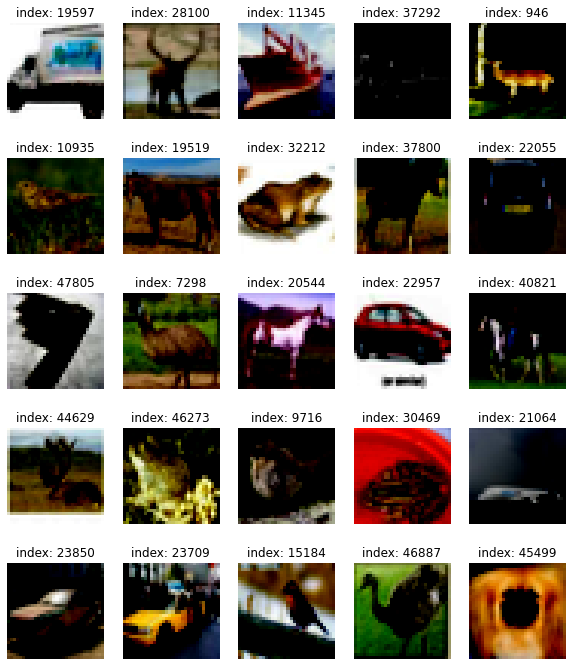

In [ ]:
plt.figure(figsize = (10, 12))

for i in range(25):
    plt.subplot(5, 5, i + 1)
    random_index = np.random.randint(1, 50000)
    plt.imshow(train_x[random_index])
    plt.title(f'index: {random_index}')
    plt.axis('off')
plt.show()

`tf.data.Dataset` 모듈의 `from_tensor_slices()` 함수를 사용하여 미니배치 데이터셋 구성합니다.

In [ ]:
# BUFFER_SIZE = 50000

BUFFER_SIZE = 10000 # STEP 8. (optional) GAN 훈련 과정 개선하기
BATCH_SIZE = 256

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### STEP 3. 생성자 모델 구현하기

* (32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수
* noise = tf.random.normal([1, 100])
* 생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인

`CIFAR-10` 데이터셋에 맞게 `(32, 32, 3)` 형태의 이미지를 생성하기 위한 생성자 모델을 구현합니다.

In [ ]:
def make_generator_model():
    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(4*4*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((4, 4, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

In [ ]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4096)              409600    
_________________________________________________________________
batch_normalization (BatchNo (None, 4096)              16384     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 4096)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

`noise = tf.random.normal([1, 100])`를 추가합니다.

In [ ]:
noise = tf.random.normal([1, 100])

In [ ]:
generated_image = generator(noise, training = False)
generated_image.shape

TensorShape([1, 32, 32, 3])

생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인해 봅시다.

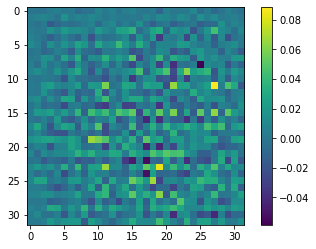

In [ ]:
# from matplotlib.colors import ListedColormap

# Ngrey = 256
# greys = np.linspace(0, 1, Ngrey)

# colors = [[g,g,g] for g in greys]

# red = [1, 0, 0]
# green = [0, 1, 0]
# blue = [0, 0, 1]

# colors[5] = red
# colors[100] = blue
# colors[200] = green

# tada = ListedColormap(colors)

plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

In [ ]:
tada = tf.cast(generated_image[0]*127.5+127.5, tf.int32)

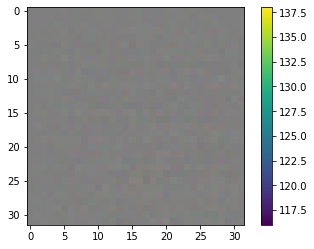

In [ ]:
plt.imshow(tada)
plt.colorbar()
plt.show()

### STEP 4. 판별자 모델 구현하기

* (32, 32, 3) 형태의 이미지 데이터를 입력으로 받아 1dim 판별 결과를 출력하는 판별자 모델 함수
* 위 STEP 2에서 생성한 랜덤 이미지를 판별자 모델이 판별한 결과값을 확인

아래는 `(32, 32, 3)` 형태의 이미지 데이터를 입력으로 받아 `1dim` 판별 결과를 출력하는 판별자 모델 함수입니다.

In [ ]:
def make_discriminator_model():
    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(32, 32, 3)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [ ]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

위 STEP 3에서 생성한 랜덤 이미지를 판별자 모델이 판별한 결과값을 확인해 봅시다.

In [ ]:
decision = discriminator(generated_image, training = False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00357217]], dtype=float32)>

### STEP 5. 손실함수와 최적화 함수 구현하기

* 손실함수 구현
* 판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수
* 생성자와 판별자를 최적화하는 optimizer 정의

`손실함수`를 구현합니다.

In [ ]:
def generator_loss(fake_output):
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
def discriminator_loss(real_output, fake_output):
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss

    return total_loss

`이미지 판별 정확도(accuracy)`를 계산하는 함수는 다음과 같습니다.

In [ ]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))

    return real_accuracy, fake_accuracy

생성자와 판별자를 최적화하는 `optimizer`를 정의합니다.

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
noise_dim = 100
num_examples_to_generate = 20

noise_vector = tf.random.normal([num_examples_to_generate, noise_dim])
print(noise_vector.shape)

(20, 100)


### STEP 6. 훈련과정 상세 기능 구현하기

* 1개 미니배치의 훈련 과정을 처리하는 train_step() 함수
* 16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images() 함수
* epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성 이미지 판별 accuracy 히스토리를 그래프로 시각화하는 draw_train_history() 함수
* training_checkpoints 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈 설정

`train_step()` 함수를 구현합니다.

In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy

16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 `generate_and_save_images()` 함수는 다음과 같습니다.

In [ ]:
def generate_and_save_images(model, epoch, it, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(8, 8))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 5, i+1)  # 4 rows, 5 columns
        plt.imshow((predictions[i].numpy()*127.5+127.5).astype(int))
        plt.axis('off')

    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))
    plt.show()

이미지 판별 accuracy 히스토리를 그래프로 시각화하는 `draw_train_history()` 함수는 다음과 같습니다.

In [ ]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

def draw_train_history(history, epoch):
    plt.subplot(211)
    plt.plot(history['gen_loss'])
    plt.plot(history['disc_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('batch iters')
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')

    plt.subplot(212)
    plt.plot(history['fake_accuracy'])
    plt.plot(history['real_accuracy'])
    plt.title('discriminator accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('batch iters')
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')

    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

training_checkpoints 디렉토리에 몇 epoch마다 모델을 저장하는 `checkpoint` 모듈을 설정해 봅시다.

In [ ]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### STEP 7. 학습 과정 진행하기

* 위 STEP 5에서 구현한 기능들을 활용하여 최소 50 epoch만큼의 모델 학습 진행
* 학습 과정에서 생성된 샘플 이미지로 만든 gif 파일을 통해 학습 진행 과정을 시각적으로 표현
* 학습 과정을 담은 샘플 이미지, gif 파일, 학습 진행 그래프 이미지를 함께 제출

In [ ]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, noise_vector)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, noise_vector)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [ ]:
# checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

# latest = tf.train.latest_checkpoint(checkpoint_dir)
# checkpoint.restore(latest)

# generator = checkpoint.generator
# discriminator = checkpoint.discriminator

# noise = tf.random.normal([1, 100])
# generated_image = generator(noise, training=False)

# np_generated = generated_image.numpy()
# np_generated = (np_generated * 127.5) + 127.5
# np_generated = np_generated.astype(int)
# plt.imshow(np_generated[0])
# plt.show()

In [ ]:
save_every = 5
EPOCHS = 200

tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

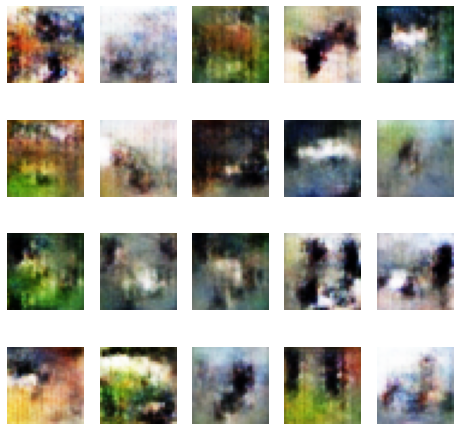

Time for training : 3649 sec


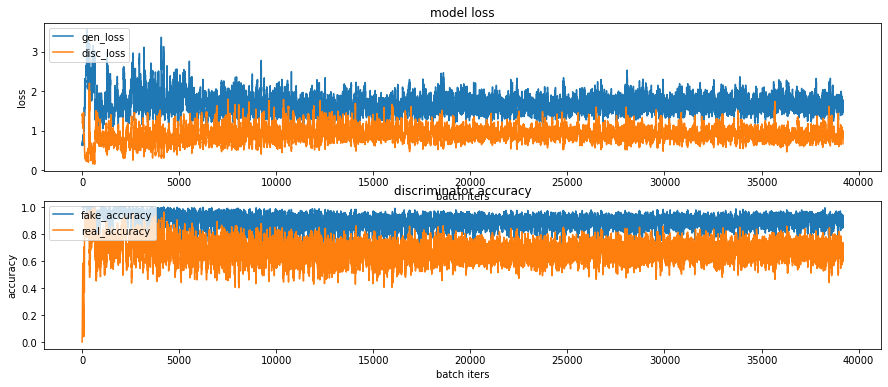

CPU times: user 1h 1min 52s, sys: 5min 21s, total: 1h 7min 14s
Wall time: 1h 52s


In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)

In [ ]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_gan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_gan.gif

-rw-r--r-- 1 root root 5477633 Nov 29 12:40 /aiffel/aiffel/dcgan_newimage/cifar10/cifar10_gan.gif


### STEP 8. (optional) GAN 훈련 과정 개선하기

**다음의 조건을 모델에 반영하여 모델을 재구성한 후 다시 학습을 진행하였고, 결과를 시각화하여 확인했습니다.**

* strided convolution이나 fractional-srided convolution을 사용하여 feature-map의 크기를 조절
* Generator 및 Discriminator 아키텍처를 조정하여 더 복잡한 네트워크 사용
* Batch normalization을 적용]
* Fully connected hidden layer 제거
* Generator 출력단의 활성함수로 tanh함수 사용, 나머지 layer는 ReLU 사용
* Discriminator의 활성함수로 LeakyReLU 사용
* Adam Optimizer의 학습률을 변경
* Learning rate decay를 적용하여 학습률을 동적으로 조정
* Epoch을 200에서 100으로 하향 조정

`Generator`의 출력 레이어에 tanh 활성화 함수를 사용하고, 나머지 레이어에서는 ReLU 활성화 함수를 적용했습니다.

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(4 * 4 * 256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    # Reshape into 4x4x256 tensor
    model.add(layers.Reshape((4, 4, 256)))

    # Conv2DTranspose layers
    model.add(layers.Conv2DTranspose(256, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    # Output layer with tanh activation
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

In [ ]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4096)              409600    
_________________________________________________________________
batch_normalization (BatchNo (None, 4096)              16384     
_________________________________________________________________
re_lu (ReLU)                 (None, 4096)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 256)         1638400   
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 256)         1024      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 8, 8, 256)         0

In [ ]:
noise = tf.random.normal([1, 100])

In [ ]:
generated_image = generator(noise, training = False)
generated_image.shape

TensorShape([1, 32, 32, 3])

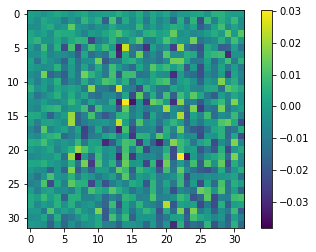

In [ ]:
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

In [ ]:
tada = tf.cast(generated_image[0]*127.5+127.5, tf.int32)

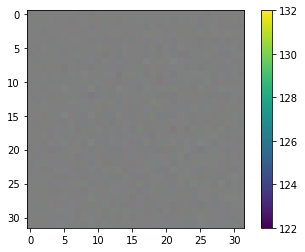

In [ ]:
plt.imshow(tada)
plt.colorbar()
plt.show()

`Discriminator`의 BatchNormalization 레이어를 추가하여 모델을 개선했습니다. LeakyReLU는 알파 값을 0.2로 설정하여 사용하였습니다.

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()

    # Conv2D layers with LeakyReLU
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(32, 32, 3)))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Flatten layer
    model.add(layers.Flatten())

    # Output layer without activation
    model.add(layers.Dense(1))

    return model

In [ ]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
batch_normalization_3 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [ ]:
decision = discriminator(generated_image, training = False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00118314]], dtype=float32)>

In [ ]:
def generator_loss(fake_output):
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
def discriminator_loss(real_output, fake_output):
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss

    return total_loss

In [ ]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))

    return real_accuracy, fake_accuracy

Adam Optimizer의 학습률을 변경, Learning rate decay를 적용하여 학습률을 동적으로 조정

In [ ]:
# Before

# generator_optimizer = tf.keras.optimizers.Adam(1e-4)
# discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# After

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

In [ ]:
noise_dim = 100
num_examples_to_generate = 20

noise_vector = tf.random.normal([num_examples_to_generate, noise_dim])
print(noise_vector.shape)

(20, 100)


In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy

In [ ]:
def generate_and_save_images(model, epoch, it, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(8, 8))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 5, i+1)  # 4 rows, 5 columns
        plt.imshow((predictions[i].numpy()*127.5+127.5).astype(int))
        plt.axis('off')

    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))
    plt.show()

In [ ]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

def draw_train_history(history, epoch):
    plt.subplot(211)
    plt.plot(history['gen_loss'])
    plt.plot(history['disc_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('batch iters')
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')

    plt.subplot(212)
    plt.plot(history['fake_accuracy'])
    plt.plot(history['real_accuracy'])
    plt.title('discriminator accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('batch iters')
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')

    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [ ]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, noise_vector)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, noise_vector)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [ ]:
save_every = 5
EPOCHS = 100 # 200에서 100으로 하향 조정

tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

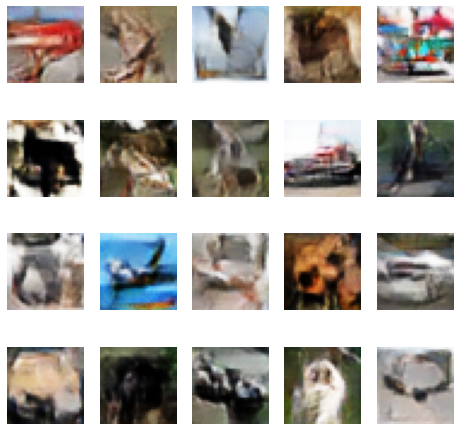

Time for training : 2646 sec


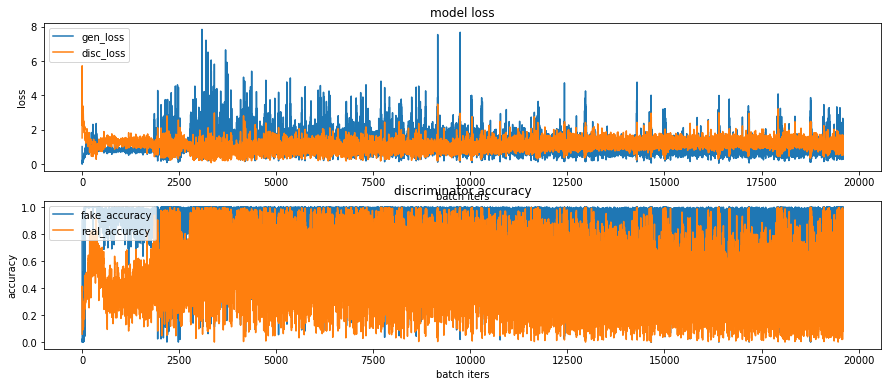

CPU times: user 44min 39s, sys: 2min 45s, total: 47min 24s
Wall time: 44min 8s


In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)

In [ ]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_recap.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_recap.gif

-rw-r--r-- 1 root root 5322004 Nov 30 03:04 /aiffel/aiffel/dcgan_newimage/cifar10/cifar10_recap.gif


## Conclusion

### Details

FASHION-MNIST 데이터 생성용 `DCGAN 모델구조`를 이용해서 `CIFAR-10` 데이터를 생성하는 모델을 제작했습니다. 이미지 데이터의 형태를 (28, 28, 1)에서 (32, 32, 3)으로 조정했고, 이를 반영하여 생성자와 판별자 모델의 입력 및 출력 형태와 모델 구조를 변경했습니다. 또한, RGB 3채널의 컬러 이미지 시각화 과정과 관련하여 고려해야 할 부분들을 추가하여 작업하였고, 결과를 확인했습니다. 모델 성능을 최적화하고, 선명한 이미지 데이터 결과를 추출하기 위해 가설을 세우고 모델에 적용했습니다. 모델을 재구성한 후 다시 학습을 진행하였으며, 결과를 시각화하여 확인했습니다. 본 실험의 결과와 회고는 다음와 같습니다.

### Result

![](https://drive.google.com/uc?export=view&id=1xXiZn_LuXwuzfeKl0QrJa6hF8_dtooGm)

Recap 진행 후, Loss가 0과 2 사이로 감소한 것을 확인할 수 있습니다. Accuracy는 굉장한 진동폭이 있었음을 알 수 있습니다.

![](https://drive.google.com/uc?export=view&id=1rvqc4_H3GIA9i5mQnXA0xIYJQKAI5pVn)

Recap 진행 후, 결과 이미지 데이터가 다소 선명해진 것을 확인할 수 있습니다. 결과 이미지 데이터를 보면 형태의 윤곽이 명확해졌고 배경과 대상을 분리하여 판단할 수 있으며, 어떤 물체인지 가늠할 수 있는 정도로 발전했습니다.

### Retrospect

>gif 형태로 결과를 생성하는 것은 흥미로운 작업이었고, 결과물을 확인하는 것이 재밌었습니다. 결과 이미지 데이터의 선명도를 높이기 위해 기존의 모델보다 조금 복잡한 형태로 모델을 재구성하는 과정에서 다양한 참고 자료가 필요했어요. 생성자와 판별자 모델에 대한 저의 가설을 적용함에 있어 적절성 여부를 판단할 수 있는 근거가 필요했습니다. dropout() 함수를 적용하므로서 이미지 데이터 추출에 리스크가 발생할 수 있다는 것을 배웠고, 모델 구현에 있어 세심한 접근이 필요하다는 것을 익힐 수 있었습니다. 또한 다양한 컬러 이미지 데이터를 사용하여 실험을 할 때와 흑백 이미지 데이터를 활용할 때 어떤 부분이 달라지는지, 달라져야 하는지 복습할 수 있어서 유익했습니다.

### Reference

* [Kaggle - GAN CIFAR10](https://www.kaggle.com/code/avk256/gan-cifar10)
* [GAN-CIFAR-10.ipynb](https://colab.research.google.com/drive/1r3InSYsSN6BgZdnyCu3vCnpZ1cniKRTJ?usp=sharing)
* [DCGAN on CIFAR-10](https://wandb.ai/sairam6087/dcgan/reports/DCGAN-on-CIFAR-10--Vmlldzo5NjMyOQ)
* [Developing a DCGAN for CIFAR-10 Dataset](https://datahacker.rs/013-developing-a-dcgan-for-cifar-10-dataset/)
* [GANs — Deep Convolutional GANs with CIFAR10 (Part 8)](https://mafda.medium.com/gans-deep-convolutional-gans-with-cifar10-part-8-be881a77e55b)
* [How to Train a GAN? Tips and tricks to make GANs work](https://github.com/soumith/ganhacks)  
* [10 Lessons I Learned Training GANs for one Year](https://towardsdatascience.com/10-lessons-i-learned-training-generative-adversarial-networks-gans-for-a-year-c9071159628)  
* [Tips for Training Stable Generative Adversarial Networks](https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/)  
* [Improved Techniques for Training GANs](https://proceedings.neurips.cc/paper_files/paper/2016/file/8a3363abe792db2d8761d6403605aeb7-Paper.pdf)  

>